# Predict a US presidential election using Bayesian optimal polling

In this tutorial, we explore the use of optimal experimental design techniques to create an optimal polling strategy to predict the outcome of the US presidential election. We take the 2012 election as our prior and the 2016 election as our test set: we imagine that we are conducting polling just before the 2016 election.

## The model
For each of the 50 states we define 

$$ \text{logit }\mathbb{P}(\text{a random voter in state } i \text{ votes Democrat in the 2016 election}) = \theta_i $$

and we assume all other voters vote Republican. Right before the election, the value of $\theta$ is unknown and we wish to estimate it using polling. The winner $w$ of the election is decided by the Electoral College system. The number of electoral college votes gained by the Democrats in state $i$ is
$$
e_i =  \begin{cases}
k_i \text{ if } \theta_i > \frac{1}{2} \\
0 \text{ otherwise}
\end{cases}
$$
(this is a rough approximation of the true system). All other electoral college votes go to the Republicans. Here $k_i$ is the number of electoral college votes alloted to state $i$, which are listed in the following data frame.

In [1]:
import pandas as pd
import torch

electoral_college_votes = pd.read_pickle("electoral_college_votes.pickle")
print(electoral_college_votes)
ec_votes_tensor = torch.tensor(electoral_college_votes.values, dtype=torch.float).squeeze()

       Electoral college votes
State                         
AL                           9
AK                           3
AZ                          11
AR                           6
CA                          55
CO                           9
CT                           7
DE                           3
DC                           3
FL                          29
GA                          16
HI                           4
ID                           4
IL                          20
IN                          11
IA                           6
KS                           6
KY                           8
LA                           8
ME                           4
MD                          10
MA                          11
MI                          16
MN                          10
MS                           6
MO                          10
MT                           3
NE                           5
NV                           6
NH                           4
NJ      

The winner $w$ of the election is

$$ w = \begin{cases}
\text{Democrats if } \sum_i e_i > \frac{1}{2}\sum_i k_i  \\
\text{Republicans otherwise}
\end{cases}
$$

We are interested in polling strategies that will help us predict $w$, rather than predicting the more complex state-by-state results $\theta$.

To set up a fully Bayesian model, we need a prior for $\theta$. We will base the prior on the outcome of some historical presidential elections. Specifically, we'll use the following dataset of state-by-state election results for the presidential elections 1996-2012 inclusive. Note that votes for parties other than Democrats and Republicans have been ignored.

In [2]:
frame = pd.read_pickle("us_presidential_election_data_1996_to_2012.pickle")
print(frame)

          1996                2000                2004                2008  \
      Democrat Republican Democrat Republican Democrat Republican Democrat   
State                                                                        
AL      662165     769044   692611     941173   693933    1176394   813479   
AK       80380     122746    79004     167398   111025     190889   123594   
AZ      653288     622073   685341     781652   893524    1104294  1034707   
AR      475171     325416   422768     472940   469953     572898   422310   
CA     5119835    3828380  5861203    4567429  6745485    5509826  8274473   
CO      671152     691848   738227     883748  1001732    1101255  1288633   
CT      735740     483109   816015     561094   857488     693826   997772   
DE      140355      99062   180068     137288   200152     171660   255459   
DC      158220      17339   171923      18073   202970      21256   245800   
FL     2546870    2244536  2912253    2912790  3583544    396452

Based on this data alone, we will base our prior mean for $\theta$ solely on the 2012 election. Specifically, we'll choose a prior mean as follows:

In [3]:
results_2012 = torch.tensor(frame[2012].values, dtype=torch.float)
prior_mean = torch.log(results_2012[..., 0] / results_2012[..., 1])
print(prior_mean)

tensor([-0.4564, -0.2947, -0.1851, -0.4961,  0.4842,  0.1100,  0.3546,  0.3825,
         2.5250,  0.0177, -0.1586,  0.9298, -0.6821,  0.3465, -0.2088,  0.1185,
        -0.4521, -0.4702, -0.3535,  0.3170,  0.5460,  0.4805,  0.1926,  0.1580,
        -0.2331, -0.1917, -0.2832, -0.4528,  0.1365,  0.1135,  0.3634,  0.2126,
         0.5884, -0.0414, -0.4104,  0.0606, -0.6979,  0.2522,  0.1094,  0.5761,
        -0.2131, -0.3730, -0.4201, -0.3231, -1.0788,  0.7652,  0.0787,  0.3075,
        -0.5613,  0.1409, -0.9032])


Our prior distribution for $\theta$ will be a multivariate Normal with mean `prior_mean`. The only thing left to decide upon is the covariance matrix.

*Aside*: The prior covariance is important in a number of ways. If we allow too much variance, the prior will be uncertain about the outcome in every state, and require polling everywhere. If we allow too little variance, we may be caught off-guard by an unexpected electoral outcome. If we assume states are independent, then we will not be able to pool information across states; but assume too much correlation and we could too faithfully base predictions about one state from poll results in another.

We select the prior covariance by taking the empirical covariance from the elections 1996 - 2012 and adding a small value `0.01` to the diagonal.

In [4]:
idx = torch.tensor([0, 2, 4, 6, 8])
as_tensor = torch.tensor(frame.values, dtype=torch.float)
logits = torch.log(as_tensor[..., idx] / as_tensor[..., idx + 1]).transpose(0, 1)
mean = logits.mean(0)
sample_covariance = (1/(logits.shape[0] - 1)) * (
    (logits.unsqueeze(-1) - mean) * (logits.unsqueeze(-2) - mean)
).sum(0)
prior_covariance = sample_covariance + 0.01 * torch.eye(sample_covariance.shape[0])
prior_scale_tril = prior_covariance.cholesky()

We are now in a position to define our Bayesian model.

In [5]:
from contextlib import ExitStack

import pyro
import pyro.distributions as dist
from pyro.contrib.util import iter_plates_to_shape

def model(polling_allocation):
    with ExitStack() as stack:
        for plate in iter_plates_to_shape(polling_allocation.shape[:-1]):
            stack.enter_context(plate)
        theta = pyro.sample("theta", dist.MultivariateNormal(prior_mean, scale_tril=prior_scale_tril))
        poll_results = pyro.sample("y", dist.Binomial(polling_allocation, logits=theta).to_event(1))
        dem_win_state = (theta > 0.).float()
        dem_electoral_college_votes = ec_votes_tensor * dem_win_state
        dem_win = dem_electoral_college_votes.sum(-1) / ec_votes_tensor.sum(-1) > .5
        pyro.sample("w", dist.Delta(dem_win))
        return poll_results, dem_win, theta

This Bayesian model implicitly defines our prior on `w`. We can investigate this prior by simulating many times from our prior.

In [6]:
_, dem_wins, theta = model(torch.ones(100000, 51))
print("Prior probability of Dem win", dem_wins.float().mean().item())

Prior probability of Dem win 0.7882400155067444


We can also investigate which states, a priori, are most marginal.

In [7]:
dem_prob = (theta > 0.).float().mean(0)
marginal = torch.argsort((dem_prob - .5).abs()).numpy()
prior_prob_dem = pd.DataFrame({"State": frame.index[marginal],
                               "Democrat win probability": dem_prob.numpy()[marginal]}).set_index('State')
print(prior_prob_dem)

       Democrat win probability
State                          
FL                      0.55407
NC                      0.39687
OH                      0.67355
VA                      0.67953
CO                      0.73171
NH                      0.78041
IA                      0.78863
NV                      0.78917
WI                      0.80645
PA                      0.81251
MN                      0.83032
GA                      0.15569
IN                      0.14710
MT                      0.12369
MO                      0.12050
NM                      0.89127
LA                      0.10633
MI                      0.89658
AZ                      0.10004
AR                      0.08153
AK                      0.06664
OR                      0.93732
SC                      0.06216
MS                      0.06205
WV                      0.05106
ME                      0.95679
ND                      0.04038
TX                      0.03695
SD                      0.03077
TN      

This is a sanity check, and seems to accord with our intuitions. Since our prior is based on 2012 and the Democrats won in 2012, it makes sense that we would favour a Democrat win in 2016 (this is before we have seen *any* polling data or incorporated any other information). Florida is frequently an important swing state and is top of our list of marginal states under the prior. We can also see states such as Pennsylvania and Wisconsin near the top of the list -- we know that these were instrumental in the 2016 election. (This kind of posthoc analysis is, of course, very bad and only engaged in by immoral persons.)

### Regional correlations

Finally, we take a closer look at our prior covariance. Specifically, we examine states that we expect to be more or less correlated.

In [29]:
import numpy as np


def correlation(cov):
    return cov / np.sqrt(np.expand_dims(np.diag(cov.values), 0) * np.expand_dims(np.diag(cov.values), 1))
                

new_england_states = ['ME', 'VT', 'NH', 'MA', 'RI', 'CT']
cov_as_frame = pd.DataFrame(prior_covariance.numpy(), columns=frame.index).set_index(frame.index)
ne_cov = cov_as_frame.loc[new_england_states, new_england_states]
ne_corr = correlation(ne_cov)
print(ne_corr)

State        ME        VT        NH        MA        RI        CT
State                                                            
ME     1.000000  0.477886  0.596116  0.356695  0.423679  0.323017
VT     0.477886  1.000000  0.499662 -0.215523 -0.024518  0.261711
NH     0.596116  0.499661  1.000000  0.225995  0.298397  0.319969
MA     0.356695 -0.215523  0.225995  1.000000  0.527190  0.208689
RI     0.423679 -0.024518  0.298397  0.527190  1.000000  0.395217
CT     0.323017  0.261710  0.319969  0.208689  0.395216  1.000000


In [40]:
pacific_states = ['CA', 'OR', 'WA']
pacific_cov = cov_as_frame.loc[pacific_states, pacific_states]
pacific_corr = correlation(pacific_cov)
print(pacific_corr)

State        CA        OR        WA
State                              
CA     1.000000  0.573579  0.502279
OR     0.573579  1.000000  0.558791
WA     0.502279  0.558791  1.000000


These correlation matrices show that, as expected, logical groupings of states tend to have similar voting trends.

In [41]:
cross_cov = cov_as_frame.loc[new_england_states + pacific_states, new_england_states + pacific_states]
cross_corr = correlation(cross_cov)
print(cross_corr.loc[new_england_states, pacific_states])

State        CA        OR        WA
State                              
ME     0.267481  0.449183  0.485293
VT     0.669012  0.716531  0.626596
NH     0.323909  0.474809  0.473340
MA    -0.240504 -0.107660  0.007864
RI     0.026399  0.051822  0.171505
CT     0.334647  0.307990  0.328485


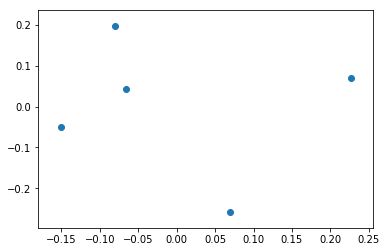

In [51]:
import matplotlib.pyplot as plt

data = (logits - mean)[...,0:2].numpy()
x, y = data[..., 0], data[..., 1]
plt.scatter(x, y)

Some of these values appear spurious, perhaps we need to more carefully set our covariance.

In [8]:
from torch import nn

class OutcomePredictor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(51, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, 1)
        
    def compute_dem_probability(self, y):
        y = F.relu(self.lin1(y))
        y = F.relu(self.lin2(y))
        return self.lin3(y)
    
    def forward(self, )

SyntaxError: invalid syntax (<ipython-input-8-4fd0aa0c0002>, line 16)